In [25]:
from scapy.all import rdpcap, IP, TCP, UDP
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.utils import resample
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import display, HTML, clear_output
import sys

In [26]:
# ===== HÜCRE 2: Konfigürasyon =====
PCAP_DIR = './'
OUTPUT_FILE = 'model_egitimi_hazir_veri.csv'
RESULTS_FILE = 'model_karsilastirma_sonuclari.csv'
PROCESSED_FILES_LOG = 'islenmis_dosyalar.txt'

In [27]:
# ===== HÜCRE 3: Global Değişkenler ve Yardımcı Fonksiyonlar =====
global_results = []
global_best_model = None
global_best_score = 0

def create_flow_key(packet):
    """Akış anahtarı oluşturur"""
    if 'IP' not in packet:
        return None
    
    ip_src = packet[IP].src
    ip_dst = packet[IP].dst
    
    if 'TCP' in packet:
        proto = 6
        port_src = packet[TCP].sport
        port_dst = packet[TCP].dport
    elif 'UDP' in packet:
        proto = 17
        port_src = packet[UDP].sport
        port_dst = packet[UDP].dport
    else:
        return None

    if ip_src > ip_dst:
        ip_src, ip_dst = ip_dst, ip_src
        port_src, port_dst = port_dst, port_src

    return (ip_src, ip_dst, port_src, port_dst, proto)

In [28]:
# ===== HÜCRE 4: PCAP İşleme Fonksiyonu (GELİŞTİRİLMİŞ) =====
def process_pcap_file(pcap_path, label):
    """PCAP dosyasından özellikleri çıkarır"""
    try:
        packets = rdpcap(pcap_path)
    except Exception as e:
        print(f"HATA: {pcap_path} dosyası okunamadı. {e}")
        return []

    flow_packets = {}
    
    for packet in packets:
        key = create_flow_key(packet)
        if key:
            if key not in flow_packets:
                flow_packets[key] = []
            
            packet_data = {
                'timestamp': float(packet.time),
                'size': int(len(packet)),
                'direction': 'fwd' if packet[IP].src == key[0] else 'bwd'
            }
            flow_packets[key].append(packet_data)

    flow_data_list = []
    
    for key, data in flow_packets.items():
        if len(data) < 2:
            continue
            
        times = [d['timestamp'] for d in data]
        sizes = [d['size'] for d in data]
        
        flow_duration = float(times[-1] - times[0])
        fwd_packets = int(sum(1 for d in data if d['direction'] == 'fwd'))
        bwd_packets = int(sum(1 for d in data if d['direction'] == 'bwd'))
        
        inter_arrival_times = [times[i+1] - times[i] for i in range(len(times)-1)]
        safe_duration = flow_duration if flow_duration > 0 else 0.001
        
        # 🆕 Yön bazlı özellikler
        fwd_sizes = [d['size'] for d in data if d['direction'] == 'fwd']
        bwd_sizes = [d['size'] for d in data if d['direction'] == 'bwd']
        
        flow_data = {
            'label': label,
            'packet_count': int(len(data)),
            'flow_duration': float(safe_duration),
            'total_size': int(sum(sizes)),
            'avg_size': float(np.mean(sizes)),
            'std_size': float(np.std(sizes)),
            'min_size': int(min(sizes)),
            'max_size': int(max(sizes)),
            'fwd_packet_count': int(fwd_packets),
            'bwd_packet_count': int(bwd_packets),
            'avg_iat': float(np.mean(inter_arrival_times)) if inter_arrival_times else 0.0,
            'std_iat': float(np.std(inter_arrival_times)) if inter_arrival_times else 0.0,
            'flow_packets_per_second': float(len(data) / safe_duration),
            'flow_bytes_per_second': float(sum(sizes) / safe_duration),
            
            # 🆕 Geliştirilmiş özellikler
            'fwd_bwd_ratio': float(fwd_packets / (bwd_packets + 1)),
            'avg_fwd_size': float(np.mean(fwd_sizes)) if fwd_sizes else 0.0,
            'avg_bwd_size': float(np.mean(bwd_sizes)) if bwd_sizes else 0.0,
            'fwd_bwd_size_ratio': float(np.mean(fwd_sizes) / (np.mean(bwd_sizes) + 1)) if fwd_sizes and bwd_sizes else 0.0,
        }
        flow_data_list.append(flow_data)
        
    return flow_data_list

In [29]:
# ===== HÜCRE 5: Tüm PCAP Dosyalarını Yükleme (İYİLEŞTİRİLMİŞ) =====
def load_all_pcap_data():
    """Sadece yeni PCAP dosyalarını yükler"""
    
    # 🆕 Daha önce işlenmiş dosyaları oku
    processed_files = set()
    if os.path.exists(PROCESSED_FILES_LOG):
        with open(PROCESSED_FILES_LOG, 'r', encoding='utf-8') as f:
            processed_files = set(line.strip() for line in f)
        print(f"ℹ️ {len(processed_files)} adet işlenmiş dosya kaydı bulundu.")
    
    # 🆕 Mevcut veriyi yükle (varsa)
    existing_df = None
    if os.path.exists(OUTPUT_FILE):
        existing_df = pd.read_csv(OUTPUT_FILE)
        print(f"✅ Mevcut veri yüklendi: {len(existing_df)} akış")
    
    # 🆕 Sadece yeni dosyaları işle
    new_flows = []
    new_files = []
    
    for root, dirs, files in os.walk(PCAP_DIR):
        for filename in files:
            if filename.endswith(".pcap"):
                pcap_path = os.path.join(root, filename)
                
                # 🆕 Daha önce işlenmiş mi kontrol et
                if pcap_path in processed_files:
                    continue  # Atla
                
                file_label = os.path.basename(root)
                print(f"🆕 YENİ DOSYA işleniyor: {pcap_path} -> {file_label}")
                
                flows = process_pcap_file(pcap_path, file_label)
                new_flows.extend(flows)
                new_files.append(pcap_path)
    
    # 🆕 Yeni veri varsa birleştir
    if new_flows:
        new_df = pd.DataFrame(new_flows)
        print(f"\n✅ {len(new_flows)} YENİ akış yüklendi")
        
        # Eski ve yeni veriyi birleştir
        if existing_df is not None:
            df = pd.concat([existing_df, new_df], ignore_index=True)
            print(f"✅ Toplam {len(df)} akış (eski + yeni)")
        else:
            df = new_df
        
        # 🆕 Güncellenmiş veriyi kaydet
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"💾 '{OUTPUT_FILE}' güncellendi")
        
        # 🆕 İşlenen dosyaları log'a ekle
        with open(PROCESSED_FILES_LOG, 'a', encoding='utf-8') as f:
            for path in new_files:
                f.write(path + '\n')
        print(f"📝 {len(new_files)} dosya '{PROCESSED_FILES_LOG}' listesine eklendi")
        
    elif existing_df is not None:
        print("ℹ️ Yeni dosya yok, mevcut veri kullanılıyor.")
        df = existing_df
    else:
        print("⚠️ Hiç veri bulunamadı!")
        return None
    
    print("\n📊 Sınıf Dağılımı:")
    print(df['label'].value_counts())
    
    print("\n📊 Ham Sınıf Dağılımı:")
    print(df['label'].value_counts())
    
    # 🆕 Hedef örnek sayısını belirle
    TARGET_SAMPLES = 2500
    min_available = df['label'].value_counts().min()
    
    # En az örneği olan sınıftan fazla alamayız
    SAMPLES_PER_CLASS = min(TARGET_SAMPLES, min_available)
    
    print(f"\n⚖️ Her sınıftan {SAMPLES_PER_CLASS} örnek alınacak")
    
    balanced_dfs = []
    for label in df['label'].unique():
        class_df = df[df['label'] == label]
        
        if len(class_df) < SAMPLES_PER_CLASS:
            # Oversample yap (tekrar eden örneklerle doldur)
            sampled = class_df.sample(n=SAMPLES_PER_CLASS, replace=True, random_state=42)
            print(f"⬆️ {label}: {len(class_df)} → {SAMPLES_PER_CLASS} (oversample)")
        else:
            # Undersample yap (fazladan veriyi at)
            sampled = class_df.sample(n=SAMPLES_PER_CLASS, random_state=42)
            print(f"⬇️ {label}: {len(class_df)} → {SAMPLES_PER_CLASS} (undersample)")
        
        balanced_dfs.append(sampled)
    
    df = pd.concat(balanced_dfs, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("\n✅ Dengelenmiş Sınıf Dağılımı:")
    print(df['label'].value_counts())
    
    return df

In [30]:
# ===== HÜCRE 6: Veri Dengeleme Fonksiyonu (YENİ) =====
def balance_data(X, y):
    """Azınlık sınıfları oversample eder"""
    unique, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    
    X_balanced = []
    y_balanced = []
    
    for label in unique:
        X_class = X[y == label]
        y_class = y[y == label]
        
        # Azınlık sınıfını çoğunluk sınıfı seviyesine çıkar
        X_resampled, y_resampled = resample(
            X_class, y_class, 
            n_samples=max_count, 
            random_state=42, 
            replace=True
        )
        X_balanced.append(X_resampled)
        y_balanced.append(y_resampled)
    
    return np.vstack(X_balanced), np.concatenate(y_balanced)

In [31]:
# ===== HÜCRE 7: Model Tanımlamaları (DÜZELTİLMİŞ) =====
def get_all_models():
    """Tüm modelleri döndürür - class_weight ve probability eklenmiş"""
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200, 
            max_depth=25, 
            min_samples_split=5,
            random_state=42, 
            n_jobs=-1, 
            class_weight='balanced'  # ✅
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, 
            learning_rate=0.1, 
            max_depth=5, 
            random_state=42
            # Not: class_weight yok, balance_data() kullanılacak
        ),
        'Decision Tree': DecisionTreeClassifier(
            max_depth=20, 
            min_samples_split=5, 
            random_state=42, 
            class_weight='balanced'  # ✅
        ),
        'SVM (RBF Kernel)': SVC(
            kernel='rbf', 
            C=10, 
            gamma='scale', 
            random_state=42, 
            class_weight='balanced',  # ✅
            probability=True  # 🆕 Olasılık tahmini için
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear', 
            C=1, 
            random_state=42, 
            class_weight='balanced',  # ✅
            probability=True  # 🆕
        ),
        'K-Nearest Neighbors': KNeighborsClassifier(
            n_neighbors=7,  # 🆕 5'ten 7'ye çıkarıldı
            weights='distance', 
            n_jobs=-1
        ),
        'Naive Bayes': GaussianNB(
            var_smoothing=1e-8  # 🆕 Düzenleme
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000, 
            random_state=42, 
            class_weight='balanced',  # ✅
            n_jobs=-1
        ),
       'AdaBoost': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),  # Stump (karar ağacı kütüğü)
            n_estimators=100, 
            learning_rate=1.0, 
            random_state=42
        ),
        'Neural Network (MLP)': MLPClassifier(
            hidden_layer_sizes=(100, 50), 
            max_iter=500, 
            random_state=42, 
            early_stopping=True,
            validation_fraction=0.1  # 🆕
        )
    }
    return models

In [32]:
# ===== HÜCRE 8: Veriyi Hazırlama =====
def prepare_data(df):
    """Veriyi train/test olarak hazırlar"""
    X = df.drop('label', axis=1)
    y = df['label']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"📊 Özellik Sayısı: {X.shape[1]}")
    print(f"📊 Sınıf Sayısı: {y.nunique()}")
    print(f"📊 Toplam Örnek: {len(df)}")
    print(f"📊  Sınıflar: {list(le.classes_)}")
    print(f"📊 Eğitim Seti: {len(X_train)} örnek")
    print(f"📊 Test Seti: {len(X_test)} örnek")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, le, X.columns

In [33]:
# ===== HÜCRE 9: Model Test Fonksiyonu (TAM DÜZELTİLMİŞ) =====
def test_model(model_name, model, X_train_scaled, y_train, X_test_scaled, y_test):
    """Tek bir modeli test eder - Gradient Boosting için özel işlem eklenmiş"""
    global global_results, global_best_model, global_best_score
    
    # HTML başlık
    display(HTML(f"""
    <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                padding: 20px; border-radius: 10px; margin: 20px 0;'>
        <h2 style='color: white; text-align: center; margin: 0;'>
            🤖 {model_name}
        </h2>
    </div>
    """))
    
    try:
        # 🆕 Gradient Boosting için veri dengeleme
        if model_name == 'Gradient Boosting':
            print("⚖️  Veri dengeleniyor...")
            X_train_balanced, y_train_balanced = balance_data(X_train_scaled, y_train)
            start_time = time.time()
            model.fit(X_train_balanced, y_train_balanced)
            train_time = time.time() - start_time
        else:
            start_time = time.time()
            model.fit(X_train_scaled, y_train)
            train_time = time.time() - start_time
        
        print(f"✅ Eğitim tamamlandı ({train_time:.2f} saniye)")
        
        # Tahmin
        sys.stdout.flush()
        start_time = time.time()
        y_pred = model.predict(X_test_scaled)
        predict_time = time.time() - start_time
        print(f"✅ Tahmin tamamlandı ({predict_time:.4f} saniye)")
        
        # Metrikler
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Cross-validation
        sys.stdout.flush()
        if model_name == 'Gradient Boosting':
            cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
        else:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        print(f"✅ Cross-validation tamamlandı")
        
        # 🆕 Sınıf bazlı rapor
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
        
        # Sonuçları DataFrame olarak göster
        results_df = pd.DataFrame({
            'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Mean', 'CV Std'],
            'Değer': [
                f'{accuracy:.2%}',
                f'{precision:.2%}',
                f'{recall:.2%}',
                f'{f1:.2%}',
                f'{cv_mean:.2%}',
                f'{cv_std:.2%}'
            ]
        })
        
        display(HTML(f"""
        <div style='background: #f0f9ff; padding: 15px; border-radius: 8px; margin: 10px 0;'>
            <h3 style='color: #1e40af; margin-top: 0;'>📊 Performans Metrikleri</h3>
            {results_df.to_html(index=False, border=0)}
            <p style='margin: 10px 0 0 0; color: #475569;'>
                ⏱️ Eğitim Süresi: <b>{train_time:.2f} saniye</b> | 
                Tahmin Süresi: <b>{predict_time:.4f} saniye</b>
            </p>
        </div>
        """))
        
        # 🆕 Sınıf bazlı performans tablosu
        class_report_df = pd.DataFrame(report).transpose().iloc[:-3, :3]  # Micro/macro avg hariç
        class_report_df.columns = ['Precision', 'Recall', 'F1-Score']
        
        display(HTML(f"""
        <div style='background: #fef3c7; padding: 15px; border-radius: 8px; margin: 10px 0;'>
            <h3 style='color: #92400e; margin-top: 0;'>🎯 Sınıf Bazlı Performans</h3>
            {class_report_df.style.format('{{:.2%}}').to_html()}
        </div>
        """))
        
        # Sonucu kaydet
        result = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'CV_Mean': cv_mean,
            'CV_Std': cv_std,
            'Train_Time': train_time,
            'Predict_Time': predict_time
        }
        global_results.append(result)
        
        # En iyi model kontrolü
        if accuracy > global_best_score:
            global_best_score = accuracy
            global_best_model = (model_name, model)
            display(HTML(f"""
            <div style='background: #dcfce7; padding: 10px; border-radius: 5px; 
                        border-left: 4px solid #16a34a;'>
                <b>🏆 YENİ EN İYİ MODEL!</b> Accuracy: {accuracy:.2%}
            </div>
            """))
        
        return model
        
    except Exception as e:
        display(HTML(f"""
        <div style='background: #fee2e2; padding: 10px; border-radius: 5px; 
                    border-left: 4px solid #dc2626;'>
            <b>❌ HATA:</b> {str(e)}
        </div>
        """))
        return None

In [34]:
# ===== HÜCRE 10: Sonuçları Karşılaştırma =====
def show_comparison():
    """Tüm model sonuçlarını karşılaştırmalı gösterir"""
    if not global_results:
        print("⚠️  Henüz test edilmiş model yok!")
        return
    
    results_df = pd.DataFrame(global_results).sort_values('Accuracy', ascending=False)
    
    display(HTML("""
    <div style='background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); 
                padding: 20px; border-radius: 10px; margin: 20px 0;'>
        <h2 style='color: white; text-align: center; margin: 0;'>
            🏆 TÜM MODELLERİN KARŞILAŞTIRMASI
        </h2>
    </div>
    """))
    
    # Tablo olarak göster
    display(results_df.style.background_gradient(cmap='RdYlGn', subset=['Accuracy', 'F1-Score'])
                            .format({'Accuracy': '{:.2%}', 'Precision': '{:.2%}', 
                                   'Recall': '{:.2%}', 'F1-Score': '{:.2%}',
                                   'CV_Mean': '{:.2%}', 'CV_Std': '{:.2%}',
                                   'Train_Time': '{:.2f}s', 'Predict_Time': '{:.4f}s'}))
    
    # En iyi 3 model
    top3 = results_df.head(3)
    display(HTML(f"""
    <div style='background: #fffbeb; padding: 15px; border-radius: 8px; margin: 20px 0;'>
        <h3 style='color: #92400e;'>🥇 En İyi 3 Model</h3>
        <ol>
            <li><b>{top3.iloc[0]['Model']}</b> - Accuracy: {top3.iloc[0]['Accuracy']:.2%}</li>
            <li><b>{top3.iloc[1]['Model']}</b> - Accuracy: {top3.iloc[1]['Accuracy']:.2%}</li>
            <li><b>{top3.iloc[2]['Model']}</b> - Accuracy: {top3.iloc[2]['Accuracy']:.2%}</li>
        </ol>
    </div>
    """))
    
    # Grafikler
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy karşılaştırması
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
    axes[0].barh(results_df['Model'], results_df['Accuracy'], color=colors)
    axes[0].set_xlabel('Accuracy', fontweight='bold')
    axes[0].set_title('Model Accuracy Karşılaştırması', fontweight='bold', fontsize=14)
    axes[0].set_xlim([0, 1])
    
    # Süre karşılaştırması
    x = np.arange(len(results_df))
    width = 0.35
    axes[1].bar(x - width/2, results_df['Train_Time'], width, label='Eğitim', color='coral')
    axes[1].bar(x + width/2, results_df['Predict_Time']*1000, width, label='Tahmin (ms)', color='skyblue')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Süre')
    axes[1].set_title('Eğitim ve Tahmin Süreleri', fontweight='bold', fontsize=14)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # CSV kaydet
    results_df.to_csv(RESULTS_FILE, index=False)
    print(f"\n💾 Sonuçlar kaydedildi: {RESULTS_FILE}")
    
    return results_df

In [35]:
# ===== HÜCRE 11: Ana Başlatma (GÜNCELLENMİŞ) =====
def initialize():
    """Jupyter Notebook başlangıcında bir kez çalıştırın"""
    global global_results, global_best_score, global_best_model
    global_results = []
    global_best_score = 0
    global_best_model = None
    
    print("🚀 Sistem başlatılıyor...")
    df = load_all_pcap_data()
    
    if df is None:
        return None
    
    return df

print("✅ Fonksiyonlar yüklendi!")

✅ Fonksiyonlar yüklendi!


In [36]:
# ===== HÜCRE 12: VERİLERİ YÜKLEME =====
print("\n📥 HÜCRE 1: Verileri yüklüyor...")
df = initialize()

# HÜCRE 2: VERİYİ HAZIRLAMA
if df is not None:
    print("\n📊 HÜCRE 2: Veri hazırlanıyor...")
    X_train, X_test, y_train, y_test, scaler, le, cols = prepare_data(df)
    models = get_all_models()
    print("\n✅ Veri hazır! Modeller yüklendi.")
    print("\n" + "="*70)
    print("🎯 MODEL TESTLERİ BAŞLIYOR")


📥 HÜCRE 1: Verileri yüklüyor...
🚀 Sistem başlatılıyor...
✅ Mevcut veri yüklendi: 22454 akış
🆕 YENİ DOSYA işleniyor: ./Download\1.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\10.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\11.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\12.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\13.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\14.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\15.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\16.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\17.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\18.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\2.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\3.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\4.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\5.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\6.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download\7.pcap -> Download
🆕 YENİ DOSYA işleniyor: ./Download

In [37]:
# 5. Veriyi Hazırlama
def prepare_data(df):
    """Veriyi train/test olarak hazırlama ve döndürme"""
    X = df.drop('label', axis=1)
    y = df['label']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f" Özellik Sayısı: {X.shape[1]}")
    print(f" Sınıf Sayısı: {y.nunique()}")
    print(f" Toplam Örnek: {len(df)}")
    print(f"  Sınıflar: {list(le.classes_)}")
    print(f" Eğitim Seti: {len(X_train)} örnek")
    print(f" Test Seti: {len(X_test)} örnek")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, le, X.columns

In [38]:
# ===== HÜCRE 13-22: MODEL TESTLERİ =====
# RANDOM FOREST
if df is not None:
    test_model('Random Forest', models['Random Forest'], 
               X_train, y_train, X_test, y_test)

✅ Eğitim tamamlandı (0.87 saniye)
✅ Tahmin tamamlandı (0.0750 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,70.04%
Precision,70.08%
Recall,70.04%
F1-Score,70.05%
CV Mean,68.09%
CV Std,0.44%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [39]:
# GRADIENT BOOSTING
if df is not None:
    test_model('Gradient Boosting', models['Gradient Boosting'], 
               X_train, y_train, X_test, y_test)

⚖️  Veri dengeleniyor...
✅ Eğitim tamamlandı (15.50 saniye)
✅ Tahmin tamamlandı (0.0195 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,65.12%
Precision,65.17%
Recall,65.12%
F1-Score,65.10%
CV Mean,73.46%
CV Std,1.01%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [40]:
# DECISION TREE
if df is not None:
    test_model('Decision Tree', models['Decision Tree'], 
               X_train, y_train, X_test, y_test)

✅ Eğitim tamamlandı (0.08 saniye)
✅ Tahmin tamamlandı (0.0010 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,66.48%
Precision,66.44%
Recall,66.48%
F1-Score,66.44%
CV Mean,63.69%
CV Std,0.71%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [41]:
# SVM (RBF KERNEL)
if df is not None:
    test_model('SVM (RBF Kernel)', models['SVM (RBF Kernel)'], 
               X_train, y_train, X_test, y_test)

✅ Eğitim tamamlandı (35.07 saniye)
✅ Tahmin tamamlandı (5.5803 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,45.88%
Precision,48.56%
Recall,45.88%
F1-Score,41.17%
CV Mean,46.44%
CV Std,0.72%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [42]:
# K-NEAREST NEIGHBORS
if df is not None:
    test_model('K-Nearest Neighbors', models['K-Nearest Neighbors'], 
               X_train, y_train, X_test, y_test)

✅ Eğitim tamamlandı (0.00 saniye)
✅ Tahmin tamamlandı (2.8288 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,69.00%
Precision,68.96%
Recall,69.00%
F1-Score,68.95%
CV Mean,67.33%
CV Std,0.28%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [43]:
# NAIVE BAYES
if df is not None:
    test_model('Naive Bayes', models['Naive Bayes'], 
               X_train, y_train, X_test, y_test)

✅ Eğitim tamamlandı (0.01 saniye)
✅ Tahmin tamamlandı (0.0030 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,26.60%
Precision,31.18%
Recall,26.60%
F1-Score,17.99%
CV Mean,26.55%
CV Std,1.04%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [44]:
# LOGISTIC REGRESSION
if df is not None:
    test_model('Logistic Regression', models['Logistic Regression'], 
               X_train, y_train, X_test, y_test)

c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


✅ Eğitim tamamlandı (0.29 saniye)
✅ Tahmin tamamlandı (0.0019 saniye)


c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n

✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,38.08%
Precision,36.37%
Recall,38.08%
F1-Score,31.99%
CV Mean,39.45%
CV Std,1.38%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [45]:
# ADABOOST

if df is not None:
    test_model('AdaBoost', models['AdaBoost'], 
               X_train, y_train, X_test, y_test)

✅ Eğitim tamamlandı (1.19 saniye)
✅ Tahmin tamamlandı (0.0347 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,40.48%
Precision,42.17%
Recall,40.48%
F1-Score,39.80%
CV Mean,42.81%
CV Std,0.47%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


In [46]:
# NEURAL NETWORK (MLP)
if df is not None:
    test_model('Neural Network (MLP)', models['Neural Network (MLP)'], 
               X_train, y_train, X_test, y_test)

✅ Eğitim tamamlandı (3.68 saniye)
✅ Tahmin tamamlandı (0.0050 saniye)
✅ Cross-validation tamamlandı


Metrik,Değer
Accuracy,48.80%
Precision,48.77%
Recall,48.80%
F1-Score,45.64%
CV Mean,48.30%
CV Std,1.29%


,Precision,Recall,F1-Score
Download,{:.2%},{:.2%},{:.2%}
Gezinti,{:.2%},{:.2%},{:.2%}
Ses,{:.2%},{:.2%},{:.2%}
Video,{:.2%},{:.2%},{:.2%}
Zoom,{:.2%},{:.2%},{:.2%}


,Model,Accuracy,Precision,Recall,F1-Score,CV_Mean,CV_Std,Train_Time,Predict_Time
0,Random Forest,70.04%,70.08%,70.04%,70.05%,68.09%,0.44%,0.87s,0.0750s
4,K-Nearest Neighbors,69.00%,68.96%,69.00%,68.95%,67.33%,0.28%,0.00s,2.8288s
2,Decision Tree,66.48%,66.44%,66.48%,66.44%,63.69%,0.71%,0.08s,0.0010s
1,Gradient Boosting,65.12%,65.17%,65.12%,65.10%,73.46%,1.01%,15.50s,0.0195s
8,Neural Network (MLP),48.80%,48.77%,48.80%,45.64%,48.30%,1.29%,3.68s,0.0050s
3,SVM (RBF Kernel),45.88%,48.56%,45.88%,41.17%,46.44%,0.72%,35.07s,5.5803s
7,AdaBoost,40.48%,42.17%,40.48%,39.80%,42.81%,0.47%,1.19s,0.0347s
6,Logistic Regression,38.08%,36.37%,38.08%,31.99%,39.45%,1.38%,0.29s,0.0019s
5,Naive Bayes,26.60%,31.18%,26.60%,17.99%,26.55%,1.04%,0.01s,0.0030s


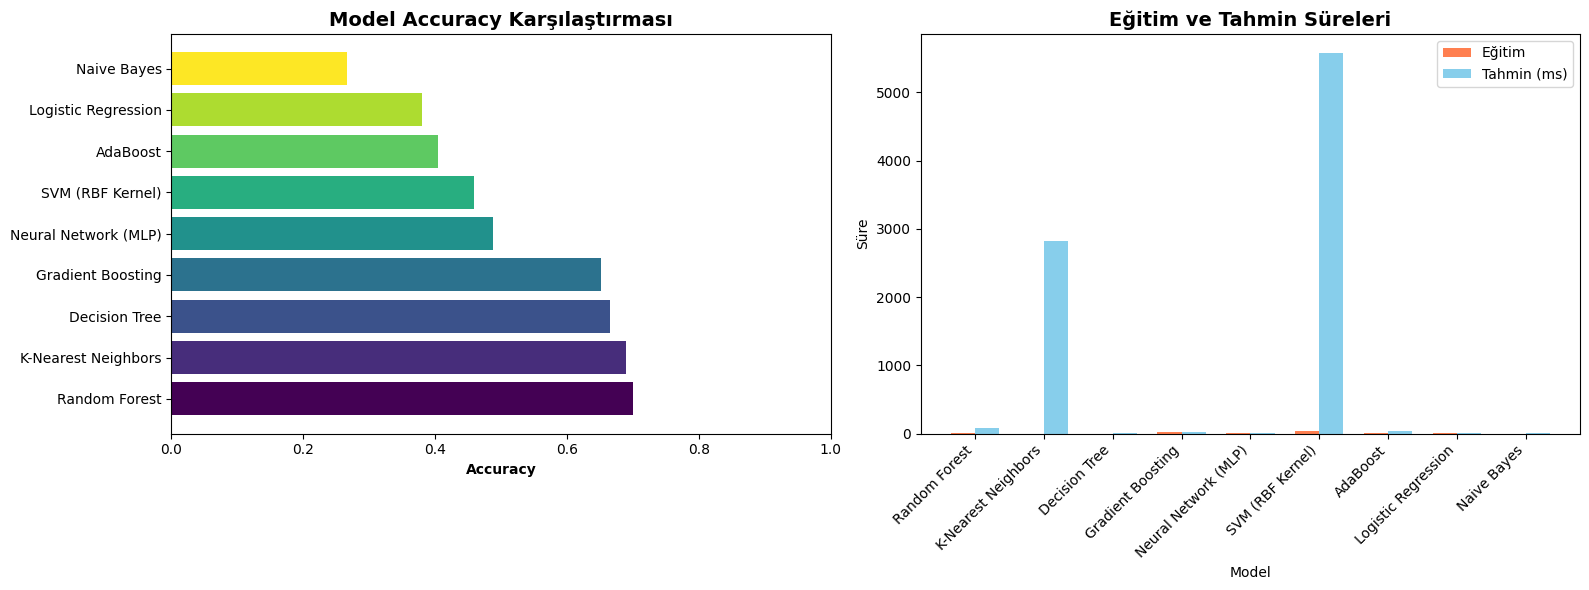


💾 Sonuçlar kaydedildi: model_karsilastirma_sonuclari.csv

🏆 En iyi model kaydedildi: best_model_Random_Forest.pkl
📊 Scaler kaydedildi: feature_scaler.pkl
📊 Label Encoder kaydedildi: label_encoder.pkl


In [47]:
# ===== HÜCRE 23: SONUÇLARI KARŞILAŞTIR =====
if df is not None:
    results = show_comparison()
    
    # En iyi modeli kaydet
    if global_best_model:
        best_name, best_model_obj = global_best_model
        joblib.dump(best_model_obj, f'best_model_{best_name.replace(" ", "_")}.pkl')
        joblib.dump(scaler, 'feature_scaler.pkl')
        joblib.dump(le, 'label_encoder.pkl')
        print(f"\n🏆 En iyi model kaydedildi: best_model_{best_name.replace(' ', '_')}.pkl")
        print(f"📊 Scaler kaydedildi: feature_scaler.pkl")
        print(f"📊 Label Encoder kaydedildi: label_encoder.pkl")

In [48]:
# ===== HÜCRE 24: TEST KLASÖRÜ TAHMİN FONKSIYONU (DÜZELTİLMİŞ) =====
def predict_test_folder_with_probs(folder_path):
    """Test klasöründeki dosyalar için tahmin yapar - Düzeltilmiş"""
    if 'global_best_model' not in globals() or global_best_model is None:
        print("❌ Hata: Eğitilmiş model bulunamadı.")
        return
    
    model_name, actual_model = global_best_model
    
    test_files = [f for f in os.listdir(folder_path) if f.endswith('.pcap')]
    if not test_files:
        print("⚠️ Klasörde .pcap dosyası bulunamadı.")
        return

    results = []
    print(f"🤖 Model: {model_name} | Olasılıklar hesaplanıyor...\n")

    for filename in test_files:
        file_path = os.path.join(folder_path, filename)
        flows = process_pcap_file(file_path, label='Tahmin')
        
        if flows:
            df_new = pd.DataFrame(flows)
            X_new = df_new.drop('label', axis=1)
            X_new_scaled = scaler.transform(X_new)
            
            # 🆕 Olasılık tahminleri
            probs = actual_model.predict_proba(X_new_scaled)
            avg_probs = np.mean(probs, axis=0)
            
            # 🆕 Düzeltilmiş tahmin yöntemi - argmax kullan
            final_label_idx = np.argmax(avg_probs)  # Mode yerine ortalama olasılığa göre
            final_label = le.inverse_transform([final_label_idx])[0]
            
            # Olasılıkları kategori isimleriyle eşleştir
            prob_dict = {le.classes_[i]: f"%{avg_probs[i]*100:.2f}" for i in range(len(le.classes_))}
            
            res_entry = {"Dosya": filename, "Baskın Tahmin": final_label}
            res_entry.update(prob_dict)
            results.append(res_entry)
            
            print(f"✅ {filename} işlendi.")

    # Sonuçları tablo olarak bastır
    result_df = pd.DataFrame(results)
    display(HTML("<h3 style='color: #2c3e50;'>📊 Dosya Bazlı Tahmin Olasılıkları</h3>"))
    display(result_df)
    
    # 🆕

In [49]:
predict_test_folder_with_probs(r'C:\Users\tunah\Desktop\Test')

🤖 Model: Random Forest | Olasılıklar hesaplanıyor...

✅ download_deneme.pcap işlendi.
✅ gezinti_deneme.pcap işlendi.
✅ ses_deneme.pcap işlendi.
✅ video_deneme.pcap işlendi.
✅ zoom_deneme.pcap işlendi.


,Dosya,Baskın Tahmin,Download,Gezinti,Ses,Video,Zoom
0,download_deneme.pcap,Ses,%18.24,%19.25,%38.01,%16.73,%7.78
1,gezinti_deneme.pcap,Gezinti,%9.30,%60.51,%12.13,%10.19,%7.88
2,ses_deneme.pcap,Ses,%17.53,%13.74,%38.77,%19.31,%10.64
3,video_deneme.pcap,Ses,%18.07,%11.98,%33.21,%22.50,%14.24
4,zoom_deneme.pcap,Ses,%17.03,%9.72,%28.97,%26.70,%17.59


In [50]:
# KURTARMA KODU (Bu hücreyi en sonda boş bir yerde çalıştır)
if 'df' in locals() and df is not None:
    # 1. Mevcut veriyi hemen CSV'ye yaz (Zaten yüklü olanları korur)
    df.to_csv(OUTPUT_FILE, index=False)
    
    # 2. Mevcut dosyaları "işlendi" olarak log dosyasına kaydet
    processed_count = 0
    with open(PROCESSED_FILES_LOG, 'w', encoding='utf-8') as f:
        for root, dirs, files in os.walk(PCAP_DIR):
            for filename in files:
                if filename.endswith(".pcap"):
                    pcap_path = os.path.join(root, filename)
                    f.write(pcap_path + '\n')
                    processed_count += 1
    
    print(f"BAŞARILI: {len(df)} adet akış '{OUTPUT_FILE}' dosyasına kaydedildi.")
    print(f"BAŞARILI: {processed_count} adet PCAP dosyası '{PROCESSED_FILES_LOG}' listesine eklendi.")
    print("Artık klasörlerine yeni veriler ekleyip sadece onları yükletebilirsin.")
else:
    print("HATA: RAM üzerinde 'df' değişkeni bulunamadı. Önce veri yükleme hücresini çalıştırmış olmalısın.")

BAŞARILI: 12500 adet akış 'model_egitimi_hazir_veri.csv' dosyasına kaydedildi.
BAŞARILI: 101 adet PCAP dosyası 'islenmis_dosyalar.txt' listesine eklendi.
Artık klasörlerine yeni veriler ekleyip sadece onları yükletebilirsin.


In [51]:
# Hangi dosyalar işlendi?
if os.path.exists(PROCESSED_FILES_LOG):
    with open(PROCESSED_FILES_LOG, 'r', encoding='utf-8') as f:
        print("📂 İşlenmiş dosyalar:")
        for line in f:
            print(f"  ✓ {line.strip()}")

📂 İşlenmiş dosyalar:
  ✓ ./Download\1.pcap
  ✓ ./Download\10.pcap
  ✓ ./Download\11.pcap
  ✓ ./Download\12.pcap
  ✓ ./Download\13.pcap
  ✓ ./Download\14.pcap
  ✓ ./Download\15.pcap
  ✓ ./Download\16.pcap
  ✓ ./Download\17.pcap
  ✓ ./Download\18.pcap
  ✓ ./Download\2.pcap
  ✓ ./Download\3.pcap
  ✓ ./Download\4.pcap
  ✓ ./Download\5.pcap
  ✓ ./Download\6.pcap
  ✓ ./Download\7.pcap
  ✓ ./Download\8.pcap
  ✓ ./Download\9.pcap
  ✓ ./Gezinti\1.pcap
  ✓ ./Gezinti\10.pcap
  ✓ ./Gezinti\2.pcap
  ✓ ./Gezinti\3.pcap
  ✓ ./Gezinti\4.pcap
  ✓ ./Gezinti\5.pcap
  ✓ ./Gezinti\6.pcap
  ✓ ./Gezinti\7.pcap
  ✓ ./Gezinti\8.pcap
  ✓ ./Gezinti\9.pcap
  ✓ ./Ses\1.pcap
  ✓ ./Ses\10.pcap
  ✓ ./Ses\11.pcap
  ✓ ./Ses\12.pcap
  ✓ ./Ses\13.pcap
  ✓ ./Ses\14.pcap
  ✓ ./Ses\15.pcap
  ✓ ./Ses\16.pcap
  ✓ ./Ses\17.pcap
  ✓ ./Ses\18.pcap
  ✓ ./Ses\19.pcap
  ✓ ./Ses\2.pcap
  ✓ ./Ses\20.pcap
  ✓ ./Ses\21.pcap
  ✓ ./Ses\22.pcap
  ✓ ./Ses\23.pcap
  ✓ ./Ses\24.pcap
  ✓ ./Ses\25.pcap
  ✓ ./Ses\26.pcap
  ✓ ./Ses\27.pcap
  ✓ .

In [52]:
# Veri durumu
print(f"📊 Toplam akış sayısı: {len(df) if 'df' in locals() else 0}")
print(f"📁 İşlenmiş dosya sayısı: {len(open(PROCESSED_FILES_LOG).readlines()) if os.path.exists(PROCESSED_FILES_LOG) else 0}")

📊 Toplam akış sayısı: 12500
📁 İşlenmiş dosya sayısı: 101
